---
# Epochs with different stimulus durations

In [2]:
from linescanning import (
    utils,
    plotting,
    fitting,
    preproc,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import holeresponse as hr
opj = os.path.join

In [3]:
# import subject dictionary containing useful information
subj_obj = hr.utils.SubjectsDict()
subj_obj.get_colors()

['#1B9E77', '#D95F02', '#4c75ff']

In [6]:
# get h5-file
deriv = "/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives"
repo_dir = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse"

subj = "sub-010"
h5 = utils.FindFiles(opj(deriv, "lsprep", subj), extension="h5").files
h5_files = utils.get_file_from_substring([subj], h5, exclude="ica")
h5_files

['/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-010/sub-010_ses-3_desc-preproc_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-010/sub-010_ses-4_desc-preproc_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-010/sub-010_ses-5_desc-preproc_bold.h5']

In [7]:
# parse h5-files
objs = {}
interval = [-2,14]
for task,h5,excl in zip(
    ["orig","long"], 
    h5_files[1:],
    [True,False]):
    
    objs[task] = {}
    h5_obj = hr.data.H5Parser(
        h5,
        verbose=True,
        compartments=20,
        excl_runs=excl
    )
    objs[task]["obj"] = h5_obj

    # avg epoch
    onsets = hr.data.average_tasks(h5_obj.df_onsets)
    print("Epoching average")
    sub_ep = fitting.Epoch(
        h5_obj.df_avg.groupby(["subject","task","t"]).mean(),
        onsets,
        TR=0.105,
        interval=interval
    )
    objs[task]["avg_epoch"] = sub_ep

    # ribbon epoch
    print("Epoching ribbon")
    comp_ep = fitting.Epoch(
        h5_obj.df_comps.groupby(["subject","task","t"]).mean(),
        onsets,
        TR=0.105,
        interval=interval
    )
    objs[task]["ribbon_epoch"] = comp_ep

    # whole line epoch
    print("Epoching line")
    comp_li = fitting.Epoch(
        h5_obj.df_func.groupby(["subject","task","t"]).mean(),
        onsets,
        TR=0.105,
        interval=interval
    )
    objs[task]["line_epoch"] = comp_li    

    # ribbon epoch
    print("Epoching WM")
    comp_wm = fitting.Epoch(
        h5_obj.df_wm.groupby(["subject","task","t"]).mean(),
        onsets,
        TR=0.105,
        interval=interval
    )
    objs[task]["wm_epoch"] = comp_wm    

DATASET
Reading from /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-010/sub-010_ses-4_desc-preproc_bold.h5
 Set attribute: df_blinks
 Set attribute: df_func_ica
 Set attribute: df_func_psc
 Set attribute: df_func_raw
 Set attribute: df_onsets
 Set attribute: df_responses
 Could not set attribute 'df_saccades'
 Set attribute: df_space_eye
 Set attribute: df_space_func

DATASET: created
Fetching dataframe from attribute 'df_func_psc'
Low-pass filtering data
Inverting ribbon order
Making 20 GM-compartments
Making 5 WM-compartments
Done with 'sub-010'

Epoching average
Epoching ribbon
Epoching line
Epoching WM
DATASET
Reading from /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-010/sub-010_ses-5_desc-preproc_bold.h5
 Set attribute: df_blinks
 Set attribute: df_func_acomp
 Set attribute: df_func_psc
 Set attribute: df_func_raw
 Set attribute: df_onsets
 Set attribute: df_responses
 Could not set attribute 'df_saccades'
 Set attribute: df_spac

In [8]:
list(objs.keys())

['orig', 'long']

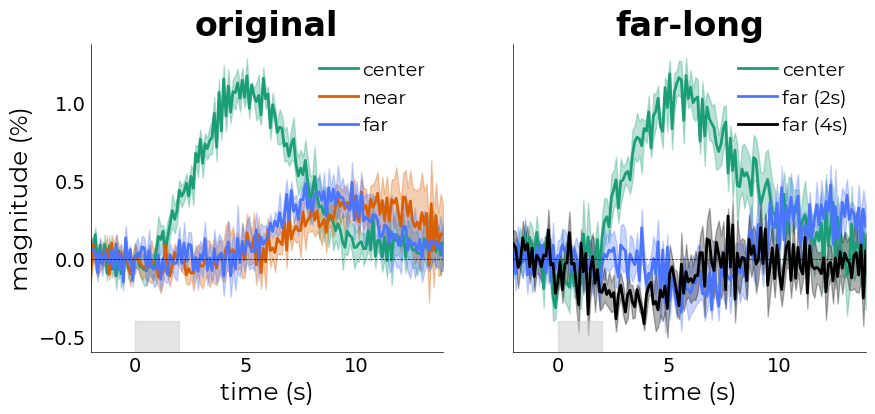

In [9]:
%matplotlib inline
fig,axs = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

tags = [
    "original",
    "far-long"
]

lbls = [
    ["center","near","far"],
    ["center","far (2s)","far (4s)"]
]

orig_colors = subj_obj.get_colors()
cms = [
    orig_colors,
    [orig_colors[0],orig_colors[-1],"k"]
]

for ix,(key,title,evs,colors) in enumerate(zip(
    list(objs.keys()),
    tags,
    lbls,
    cms)):
    
    if ix == 0:
        y_lbl = "magnitude (%)"
    else:
        y_lbl = None
        
    select_ses = objs[key]["avg_epoch"].df_epoch
    avg_epoch = hr.viz.PlotEpochProfiles(
        select_ses.groupby(["event_type","epoch","t"]).mean()["gm"],
        axs=axs[ix],
        ev_names=evs,
        cm=colors,
        y_label=y_lbl
    )

    axs[ix].set_title(title, fontsize=24, fontweight="bold")

## Laminar profiles

In [11]:
for key,val in objs.items():
    print(f"{key}: {val}")

orig: {'obj': <holeresponse.data.H5Parser object at 0x7fab790926a0>, 'avg_epoch': <linescanning.fitting.Epoch object at 0x7fab69a99850>, 'ribbon_epoch': <linescanning.fitting.Epoch object at 0x7fab69afdee0>, 'line_epoch': <linescanning.fitting.Epoch object at 0x7fab8e562100>, 'wm_epoch': <linescanning.fitting.Epoch object at 0x7fab69afd730>}
long: {'obj': <holeresponse.data.H5Parser object at 0x7fab43785070>, 'avg_epoch': <linescanning.fitting.Epoch object at 0x7fab47fac880>, 'ribbon_epoch': <linescanning.fitting.Epoch object at 0x7fab482c7310>, 'line_epoch': <linescanning.fitting.Epoch object at 0x7fab43470580>, 'wm_epoch': <linescanning.fitting.Epoch object at 0x7fab43ac7790>}


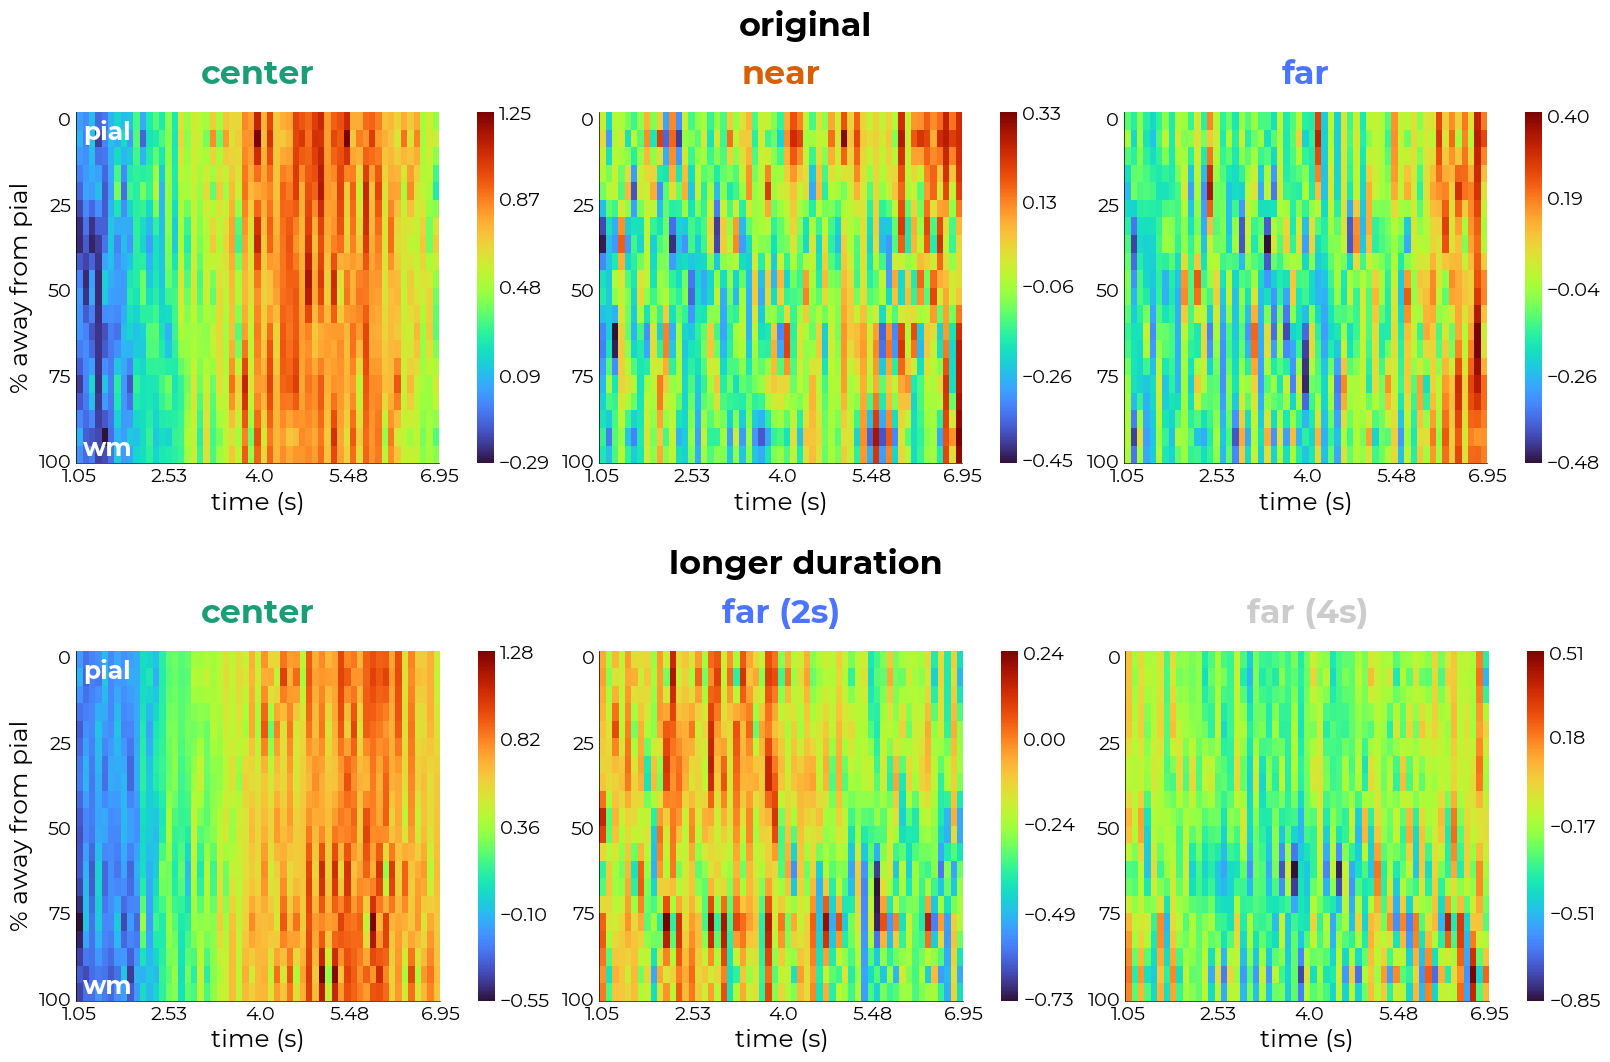

In [10]:
fig = plt.figure(
    figsize=(16,10), 
    constrained_layout=True
)

sf = fig.subfigures(nrows=len(objs), hspace=0.15)

titles = [
    "original",
    "longer duration"
]

cms = [
    orig_colors,
    [orig_colors[0],orig_colors[-1],"#cccccc"]
]

evs = [
    ["center","near","far"],
    ["center","far (2s)","far (4s)"]
]

for ix,(key,val) in enumerate(objs.items()):

    sf_ = sf[ix]
    xy_avg = hr.viz.XinYuPlot(
        val["ribbon_epoch"].df_epoch.groupby(["event_type","epoch","t"]).mean(),
        axs=sf_,
        show_time=[1,7],
        ev_names=evs[ix],
        ev_colors=cms[ix],
        cm="turbo",
        time_ticks=5,
        depth_ticks=5,
        cb_kws={
            "cm_decimal": 2
        },
        title=titles[ix]
    )


## White matter

In [12]:
val["wm_epoch"].df_epoch.groupby(["event_type","epoch","t"]).mean()

0         1         2         3         4
event_type  epoch t                                                           
act         0     -2.000000  -0.299939  0.337872  0.882186  0.903751  0.478296
                  -1.894737  -0.539857 -1.421425 -2.760135 -1.806761 -1.082103
                  -1.789474  -0.797361  0.459515  1.559794  1.741596  0.624590
                  -1.684211   0.321332 -0.395698 -1.258990 -1.371634 -0.315497
                  -1.578947  -0.267832  0.113826  1.051386  1.822042  1.157151
...                                ...       ...       ...       ...       ...
suppr_short 4      13.473684 -0.346815 -0.680603  0.085040 -0.548771 -0.033967
                   13.578947 -0.370023  1.094341 -0.897219 -0.274224 -0.126778
                   13.684211 -0.514964 -0.859823  0.433138 -1.331285 -0.657734
                   13.789474 -0.288386 -0.408529 -1.309142 -0.471722  0.379973
                   13.894737 -1.057955  0.499396 -0.244186 -1.422041 -0.730251

[2280 rows x 5 columns]

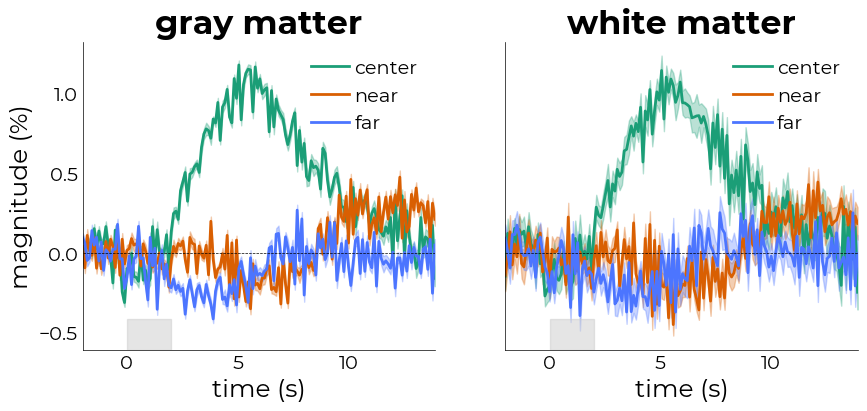

In [14]:
%matplotlib inline
fig,axs = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

tags = [
    "gray matter",
    "white matter"
]

lbls = [
    ["center","near","far"],
    ["center","far (2s)","far (4s)"]
]

orig_colors = subj_obj.get_colors()
for ix,(col,tag) in enumerate(zip(
    ["ribbon_epoch","line_epoch"],
    tags)):
    
    if ix == 0:
        y_lbl = "magnitude (%)"
    else:
        y_lbl = None
        
    select_ses = objs["long"][col].df_epoch

    if col == "line_epoch":
        rrange = (355,360)
        select_ses = utils.select_from_df(
            select_ses,
            expression="ribbon",
            indices=rrange
        )

    avg_epoch = hr.viz.PlotEpochProfiles(
        select_ses.groupby(["event_type","epoch","t"]).mean(),
        axs=axs[ix],
        ev_names=["center","near","far"],
        cm=subj_obj.get_colors(),
        y_label=y_lbl
    )

    axs[ix].set_title(tag, fontsize=24, fontweight="bold")

In [27]:
objs["long"]["line_epoch"].df_epoch

vox 0     vox 1     vox 2  \
subject task run event_type  epoch t                                          
010     SRFa 1   act         0     -2.000000   3.457375  5.701965  1.737354   
                                   -1.894737   3.214815 -0.438019  5.409723   
                                   -1.789474  -8.724136 -0.565166  0.311838   
                                   -1.684211   2.006655  3.094442  3.504139   
                                   -1.578947  -2.899202  0.889935 -2.142757   
...                                                 ...       ...       ...   
        SRFb 1   suppr_short 4      13.473684  0.672125  5.175348 -0.134096   
                                    13.578947 -0.170872 -5.577866 -1.733381   
                                    13.684211 -2.419065  1.151197  6.267059   
                                    13.789474 -0.144440 -2.499023  2.735907   
                                    13.894737  4.954895 -2.146656  3.561457   

                                                  vox 3     vox 4     vox 5  \
subject task run event_type  epoch t                                          
010     SRFa 1   act         0     -2.000000  -1.213697  1.655626  2.228664   
                                   -1.894737  -2.856968  0.647448  2.425270   
                                   -1.789474   4.399914  0.465990  5.518276   
                                   -1.684211   2.444695  4.689501  3.334738   
                                   -1.578947   3.193411 -5.025286  2.019564   
...                                                 ...       ...       ...   
        SRFb 1   suppr_short 4      13.473684 -1.735527  1.969276 -0.259077   
                                    13.578947 -3.573576 -4.004160 -1.396671   
                                    13.684211 -1.802166  0.634363  5.712223   
                                    13.789474  3.998194 -0.745813  0.285595   
                                    13.894737 -1.619150 -2.995703 -3.766821   

                                                  vox 6     vox 7     vox 8  \
subject task run event_type  epoch t                                          
010     SRFa 1   act         0     -2.000000   4.207561  4.432604 -0.602715   
                                   -1.894737   2.461092  2.140955  0.504221   
                                   -1.789474   2.933481  0.590456  1.739126   
                                   -1.684211  -0.148941  0.271294  2.300459   
                                   -1.578947   4.598463  0.796812 -0.589457   
...                                                 ...       ...       ...   
        SRFb 1   suppr_short 4      13.473684 -1.857796  0.990576  3.025597   
                                    13.578947  1.841013 -0.363010 -8.357796   
                                    13.684211  2.215349  3.497467  1.907185   
                                    13.789474  1.287977  0.439846 -0.653322   
                                    13.894737 -1.762661 -5.843742  3.080393   

                                                  vox 9  ...    vox 710  \
subject task run event_type  epoch t                     ...              
010     SRFa 1   act         0     -2.000000   1.716429  ...  -3.663356   
                                   -1.894737  -1.618605  ...   2.497314   
                                   -1.789474  -1.590313  ...  10.237267   
                                   -1.684211   1.881323  ...  -6.402797   
                                   -1.578947  -0.720043  ...   8.956728   
...                                                 ...  ...        ...   
        SRFb 1   suppr_short 4      13.473684 -4.826557  ...   7.838556   
                                    13.578947  7.137661  ...   0.070844   
                                    13.684211  2.867815  ...   8.652660   
                                    13.789474  3.252239  ...   5.155596   
                                    13.894737  2.228691  ...  12.4

## GLM

In [40]:
# c_vec1 = [0,1,1,0,0,0]
# c_vec2 = [0,0,0,1,1]
# c_vec3 = [0,1,1,1,1]

# c_vecs = [
#     c_vec1,
#     c_vec2,
#     c_vec3
# ]

evs = utils.get_unique_ids(objs["long"][col].df_epoch, id="event_type")
add_intercept = True

if len(evs) == 5:
    # without intercept
    c_vec1 = [1,1,0,0,0,0,0,0,0,0]
    c_vec2 = [0,0,1,1,0,0,0,0,0,0]
    c_vec3 = [0,0,0,0,1,1,0,0,0,0]
    c_vec4 = [0,0,0,0,0,0,1,1,0,0]
    c_vec5 = [0,0,0,0,0,0,0,0,1,1]

    c_vecs = [
        c_vec1,
        c_vec2,
        c_vec3,
        c_vec4,
        c_vec5
    ]

elif len(evs) == 3:
    # without intercept
    c_vec1 = [1,1,0,0,0,0]
    c_vec2 = [0,0,1,1,0,0]
    c_vec3 = [0,0,0,0,1,1]

    c_vecs = [
        c_vec1,
        c_vec2,
        c_vec3,
    ]

elif len(evs) == 2:
    # without intercept
    c_vec1 = [1,1,0,0]
    c_vec2 = [0,0,1,1]

    c_vecs = [
        c_vec1,
        c_vec2
    ]

if add_intercept:
    c_vecs = [[0]+i for i in c_vecs]

# c_vec1 = [0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0]
# c_vec2 = [0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0]
# c_vec3 = [0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0]
# c_vec4 = [0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0]
# c_vec5 = [0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1]


c_vec = np.array(c_vecs)
c_vec.shape

(3, 7)

### Average ribbon

In [44]:
df_avg = objs["orig"]["obj"].df_avg.groupby(["subject","task","t"]).mean()
df_stim = hr.data.average_tasks(objs["orig"]["obj"].df_onsets)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors
t-stat [0. 1. 1. 0. 0. 0. 0.]: [27.35908419]
t-stat [0. 0. 0. 1. 1. 0. 0.]: [-5.92113646]
t-stat [0. 0. 0. 0. 0. 1. 1.]: [-1.14129536]
Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors
t-stat [0. 1. 1. 0. 0. 0. 0.]: [21.04635733]
t-stat [0. 0. 0. 1. 1. 0. 0.]: [-6.04998739]
t-stat [0. 0. 0. 0. 0. 1. 1.]: [-1.31192292]


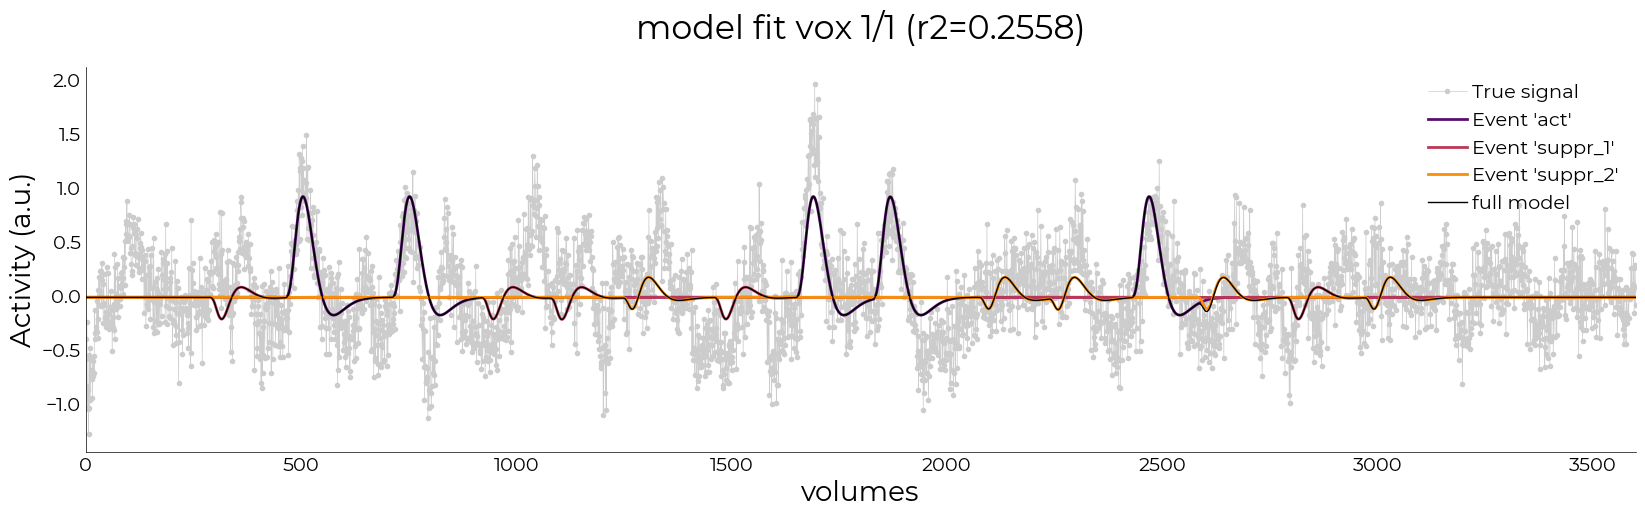

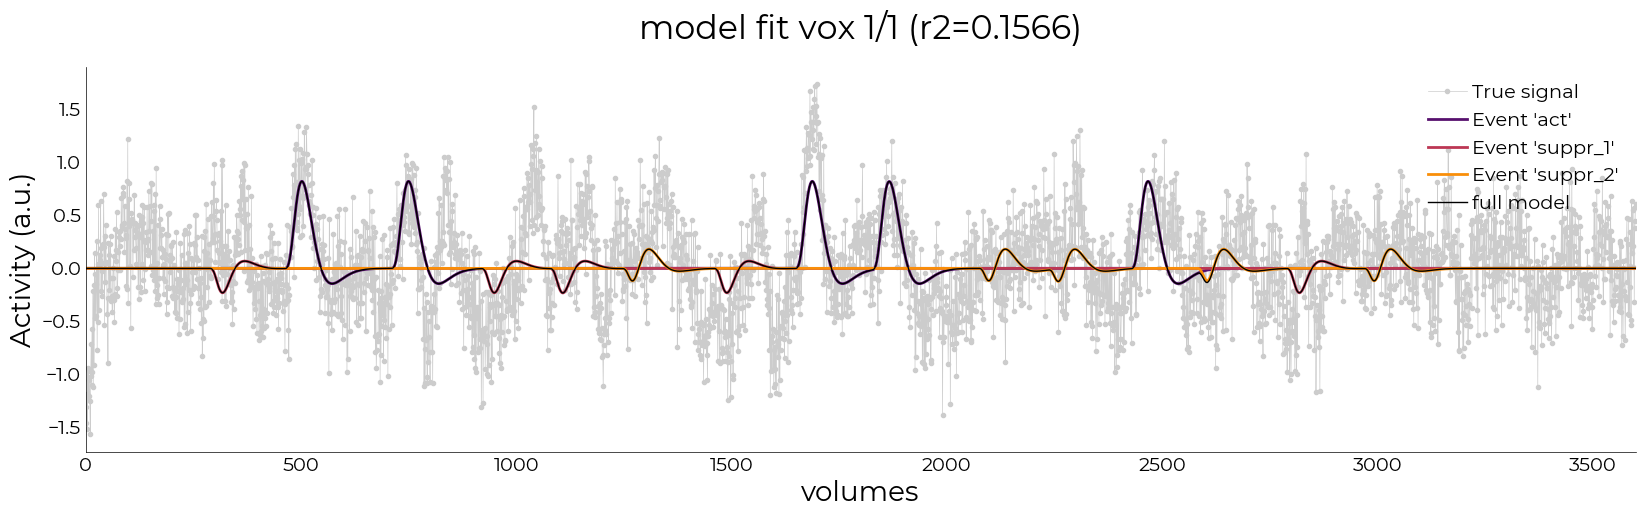

In [45]:
from linescanning import glm
fit_objs = {}

for ix,col in enumerate(list(df_avg.columns)):

    expr = "task = SRFa"
    task_df = utils.select_from_df(df_avg, expression=expr)
    fitter = glm.GenericGLM(
        utils.select_from_df(df_stim, expression=expr),
        utils.select_from_df(task_df, expression="ribbon", indices=[ix]),
        hrf_pars="glover",
        derivative=True,
        dispersion=False,
        TR=0.105, 
        osf=100, 
        verbose=True
    )

    fitter.create_design(add_intercept=add_intercept)
    fitter.fit(
        make_figure=True, 
        copes=c_vec, 
        verbose=True, 
        plot_full=True,
        add_intercept=add_intercept
    )

    fit_objs[col] = fitter

### Full line

In [46]:
df_line = objs["orig"]["obj"].df_func.groupby(["subject","task","t"]).mean()
fit_line = glm.GenericGLM(
    utils.select_from_df(df_stim, expression="task = SRFa"), 
    utils.select_from_df(df_line, expression="task = SRFa"),
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True,
    add_intercept=add_intercept
)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


(3, 720)

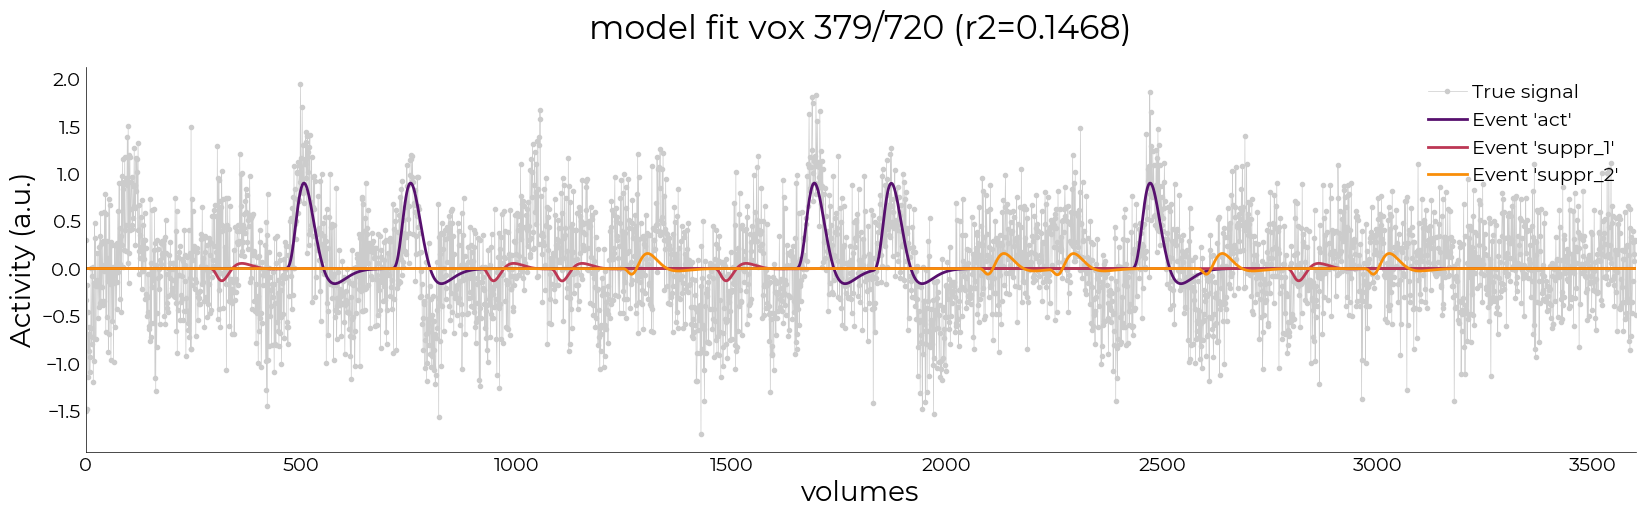

In [47]:
fit_line.create_design(add_intercept=add_intercept)
fit_line.fit(
    make_figure=True, 
    copes=c_vec, 
    add_intercept=add_intercept
)

t_line = fit_line.results["tstats"]
t_line.shape

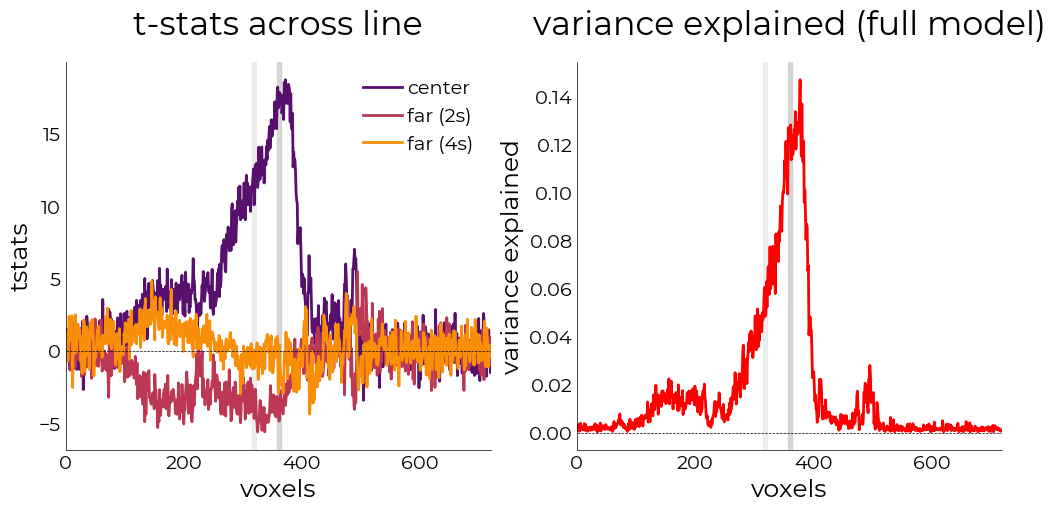

In [48]:
fig,axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
plotting.LazyPlot(
    [t_line[i] for i,_ in enumerate(fit_line.plot_event)],
    axs=axs[0],
    x_label="voxels",
    y_label="tstats",
    labels=["center","far (2s)","far (4s)"],
    line_width=2,
    cmap="inferno",
    add_hline=0,
    title="t-stats across line"
)

plotting.LazyPlot(
    fit_line.results["r2"],
    axs=axs[1],
    x_label="voxels",
    y_label="variance explained",
    line_width=2,
    color="r",
    title="variance explained (full model)",
    add_hline=0
)

for ax in axs:
    ax.axvspan(*subj_obj.get_ribbon(subj), alpha=0.8, color="#cccccc")
    ax.axvspan(*subj_obj.get_wm(subj), alpha=0.3, color="#cccccc")

## Blink regression

In [ ]:
objs["orig"]["obj"].h5_objs[subj].fetch_blinks()

onset
subject task run event_type         
010     SRFa 1   blink         0.072
                 blink         0.946
                 blink         1.175
                 blink         1.952
                 blink         2.743
...                              ...
        SRFb 4   blink       376.352
                 blink       376.802
                 blink       376.993
                 blink       377.397
                 blink       377.926

[4608 rows x 1 columns]

In [ ]:
use_obj = "long"
func = utils.multiselect_from_df(
    objs[use_obj]["obj"].dict_ribbon[subj],
    expression=[
        f"subject = 010",
        "task = SRFa",
        "run = 4"
    ]
)

eye = utils.multiselect_from_df(
    objs[use_obj]["obj"].df_onsets,
    expression=[
        "subject = 010",
        "task = SRFa",
        "run = 4",
        "event_type = act"
    ]
)

# fit FIR model
eye_fir = fitting.NideconvFitter(
    func,
    onsets=eye,
    TR=0.105,
    verbose=True,
    basis_sets="canonical_hrf_with_time_derivative",
    n_regressors="tr",
    conf_intercept=False
)
eye_fir.timecourses_condition()

Selected 'canonical_hrf_with_time_derivative'-basis sets (with 2 regressors)
Adding event 'act' to model
Fitting with 'ols' minimization
Done


In [ ]:
use_obj = "long"
func = objs[use_obj]["obj"].dict_ribbon[subj]
# onsets = objs[use_obj]["obj"].h5_objs[subj].df_onsets
onsets = objs[use_obj]["obj"].df_onsets
regr_obj = preproc.EventRegression(
    func,
    onsets,
    ses=5,
    evs=["act"],
    TR=0.105,
    # verbose=True,
    basis_sets="fir",
    n_regressors="tr",
    conf_intercept=False,
    # make_figure=True,
    plot_kw={
        # "save": True,
        "fig_dir": opj(os.path.dirname(h5_files[0]), "figures"),
        "avg": True,
    },
    reg_kw={
        "detrend": False,
        "standardize_confounds": False,
        # "low_pass": 0.1
    }
)

df_regr = regr_obj.df_regress.copy()

sub_id: 010
 event: act
  task_id: SRFa
  run_ids: ['1', '2', '3', '4']
  task_id: SRFb
  run_ids: ['1', '2', '3', '4']


In [ ]:
select = [
    "subject = 010",
    "task = SRFa",
    "run = 4"
]

f1 = utils.multiselect_from_df(
    func,
    expression=select
)

r1 = utils.multiselect_from_df(
    df_regr,
    expression=select
)
r1.head()

vox 360   vox 361   vox 362   vox 363   vox 364  \
subject task run t                                                         
010     SRFa 4   0.000 -2.000694 -0.012558 -0.455696  1.131325  0.723701   
                 0.105 -0.957993 -1.112503 -1.181244 -0.568436  0.443054   
                 0.210 -1.614296 -0.871864 -2.300804 -1.990280 -1.100037   
                 0.315 -0.486168 -0.646194 -0.517998  0.142639 -0.750504   
                 0.420 -0.834251 -0.525185  0.281418 -1.241730 -0.111328   

                         vox 365   vox 366   vox 367   vox 368  
subject task run t                                              
010     SRFa 4   0.000 -1.183571  2.496300  0.670258  0.176300  
                 0.105 -0.351715  0.321297  0.136414 -0.103401  
                 0.210 -1.456741 -2.699516 -1.901382 -1.610596  
                 0.315 -0.300194 -0.500214 -0.345734 -0.336525  
                 0.420 -1.360092 -0.872665 -1.613991 -1.596947

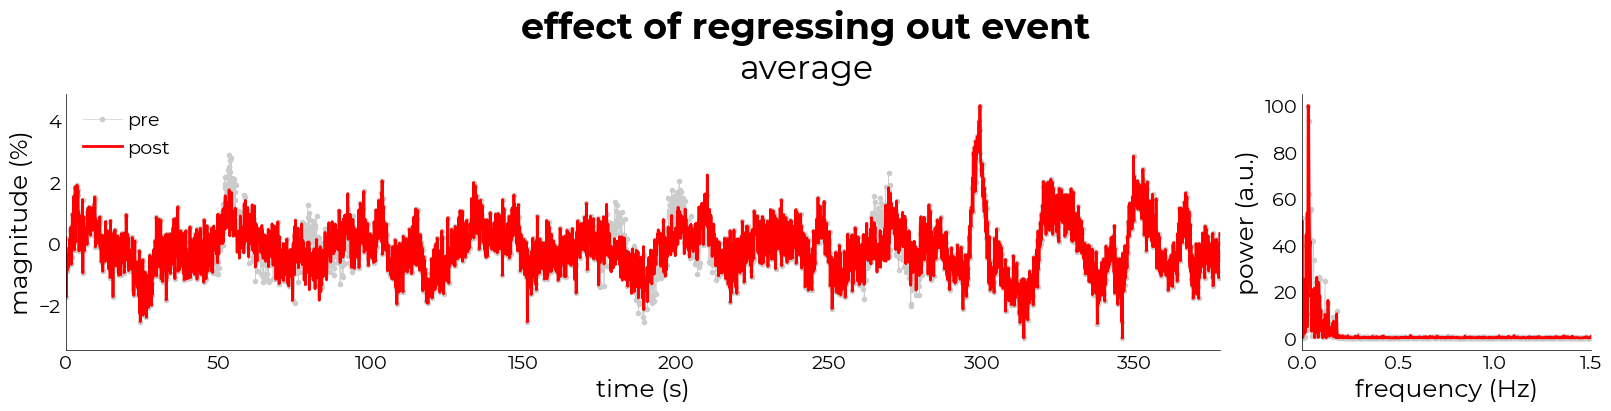

In [ ]:
preproc.EventRegression.plot_result(
    f1,
    r1,
    avg=True
)

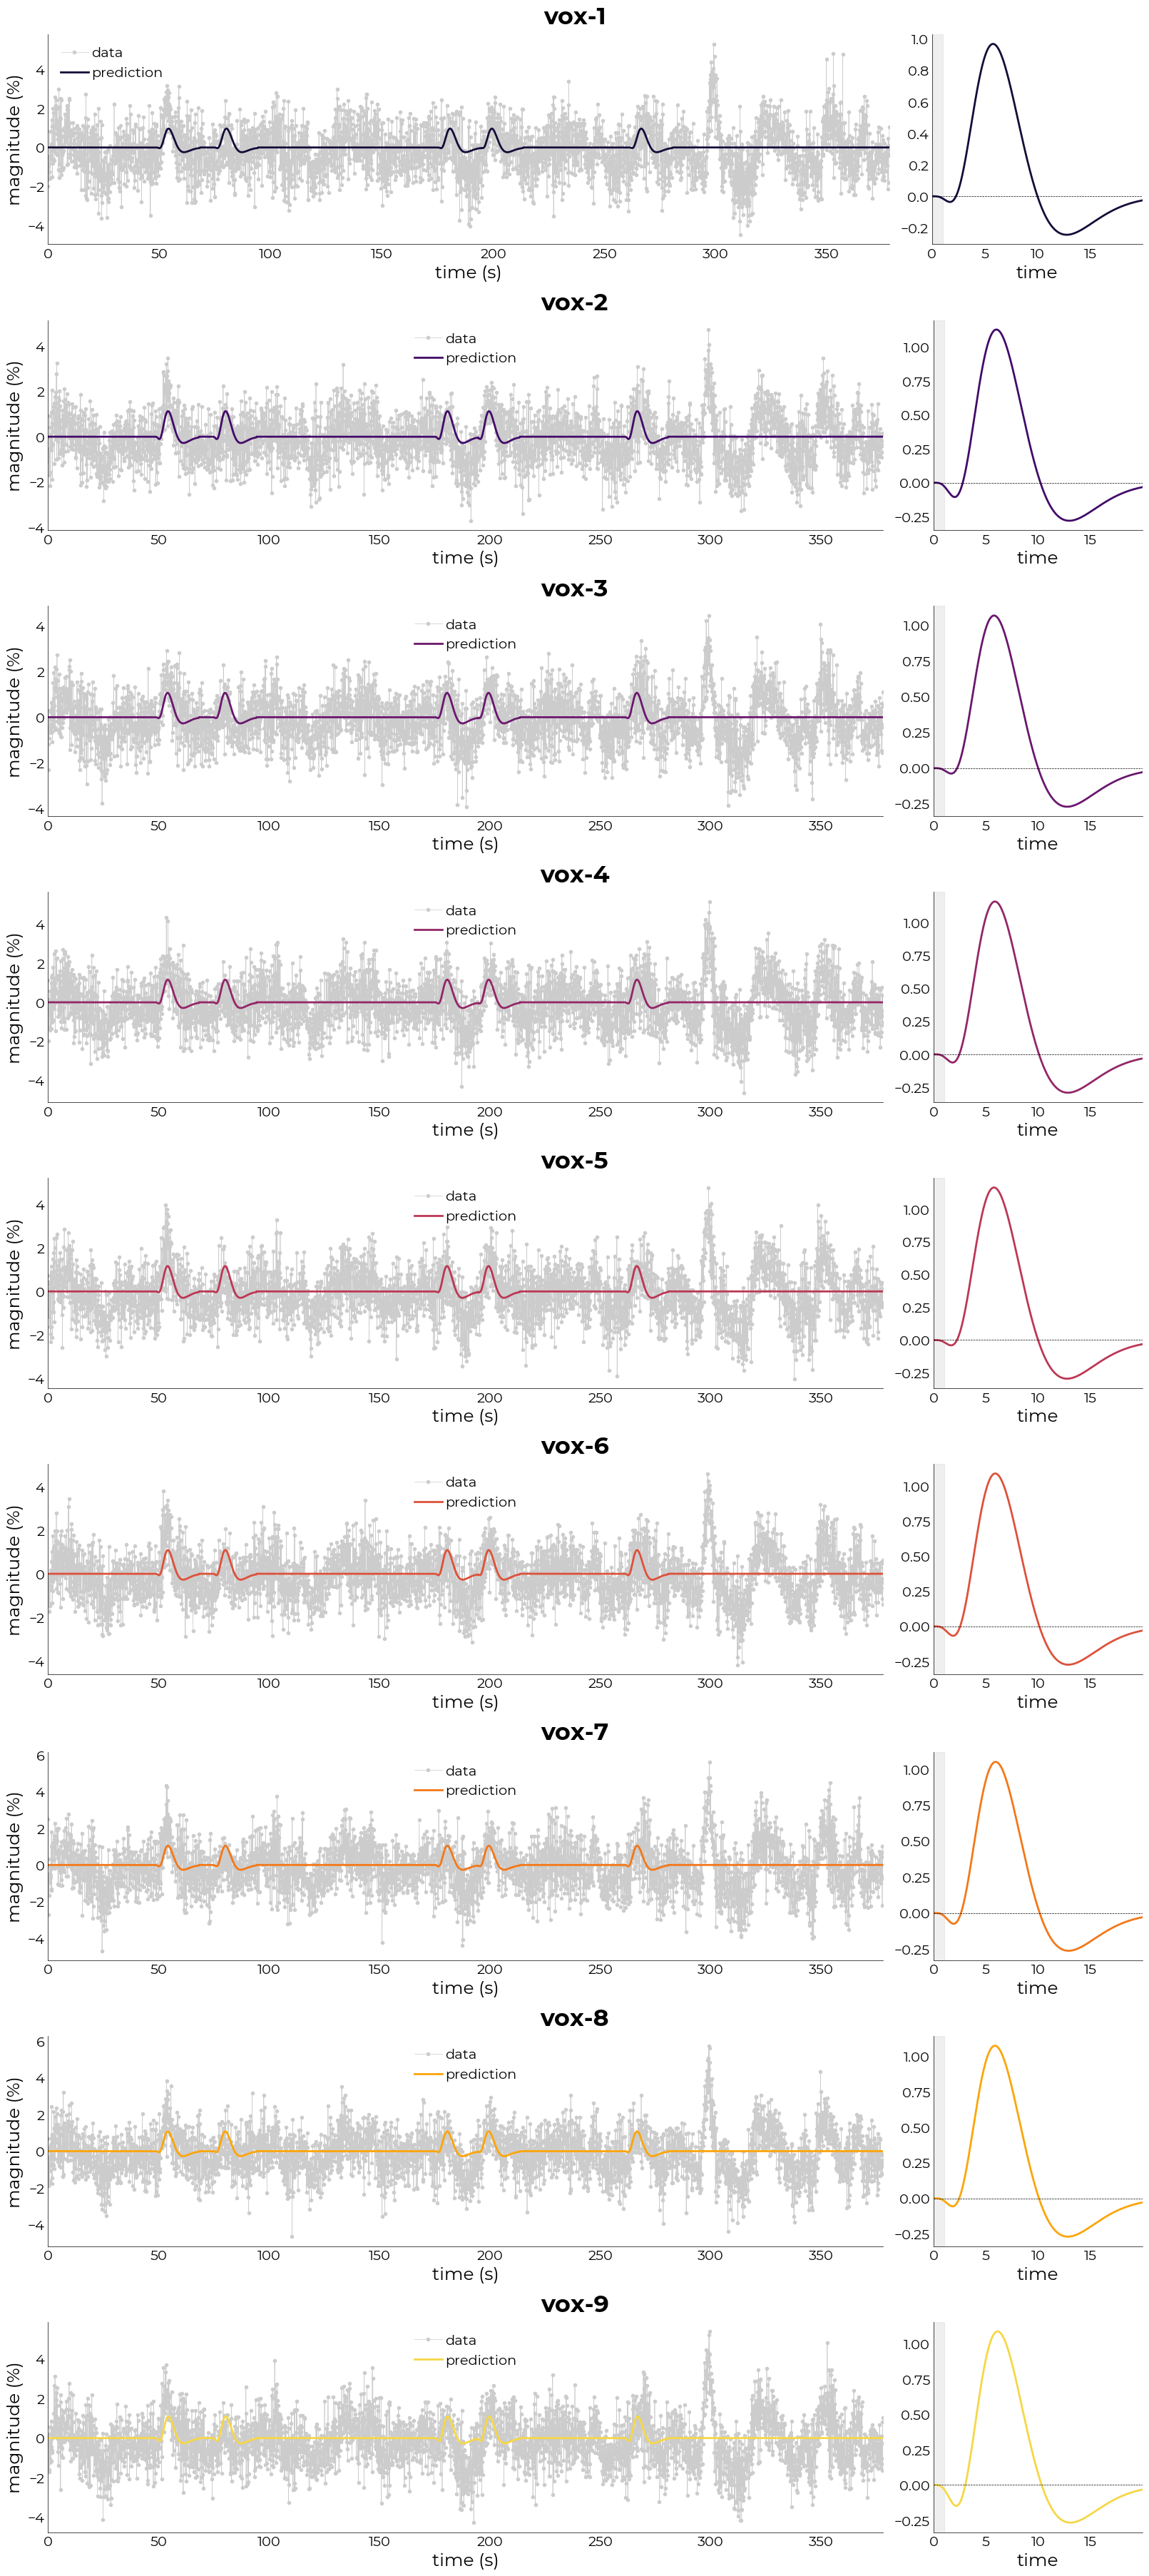

In [ ]:
preproc.EventRegression.plot_model_fits(
    eye_fir,
)

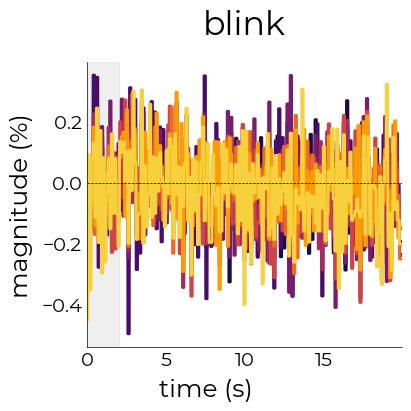

In [ ]:
hr.viz.PlotDeconvProfiles(
    eye_fir,
    inset_par=None,
    # time_par="t"
)

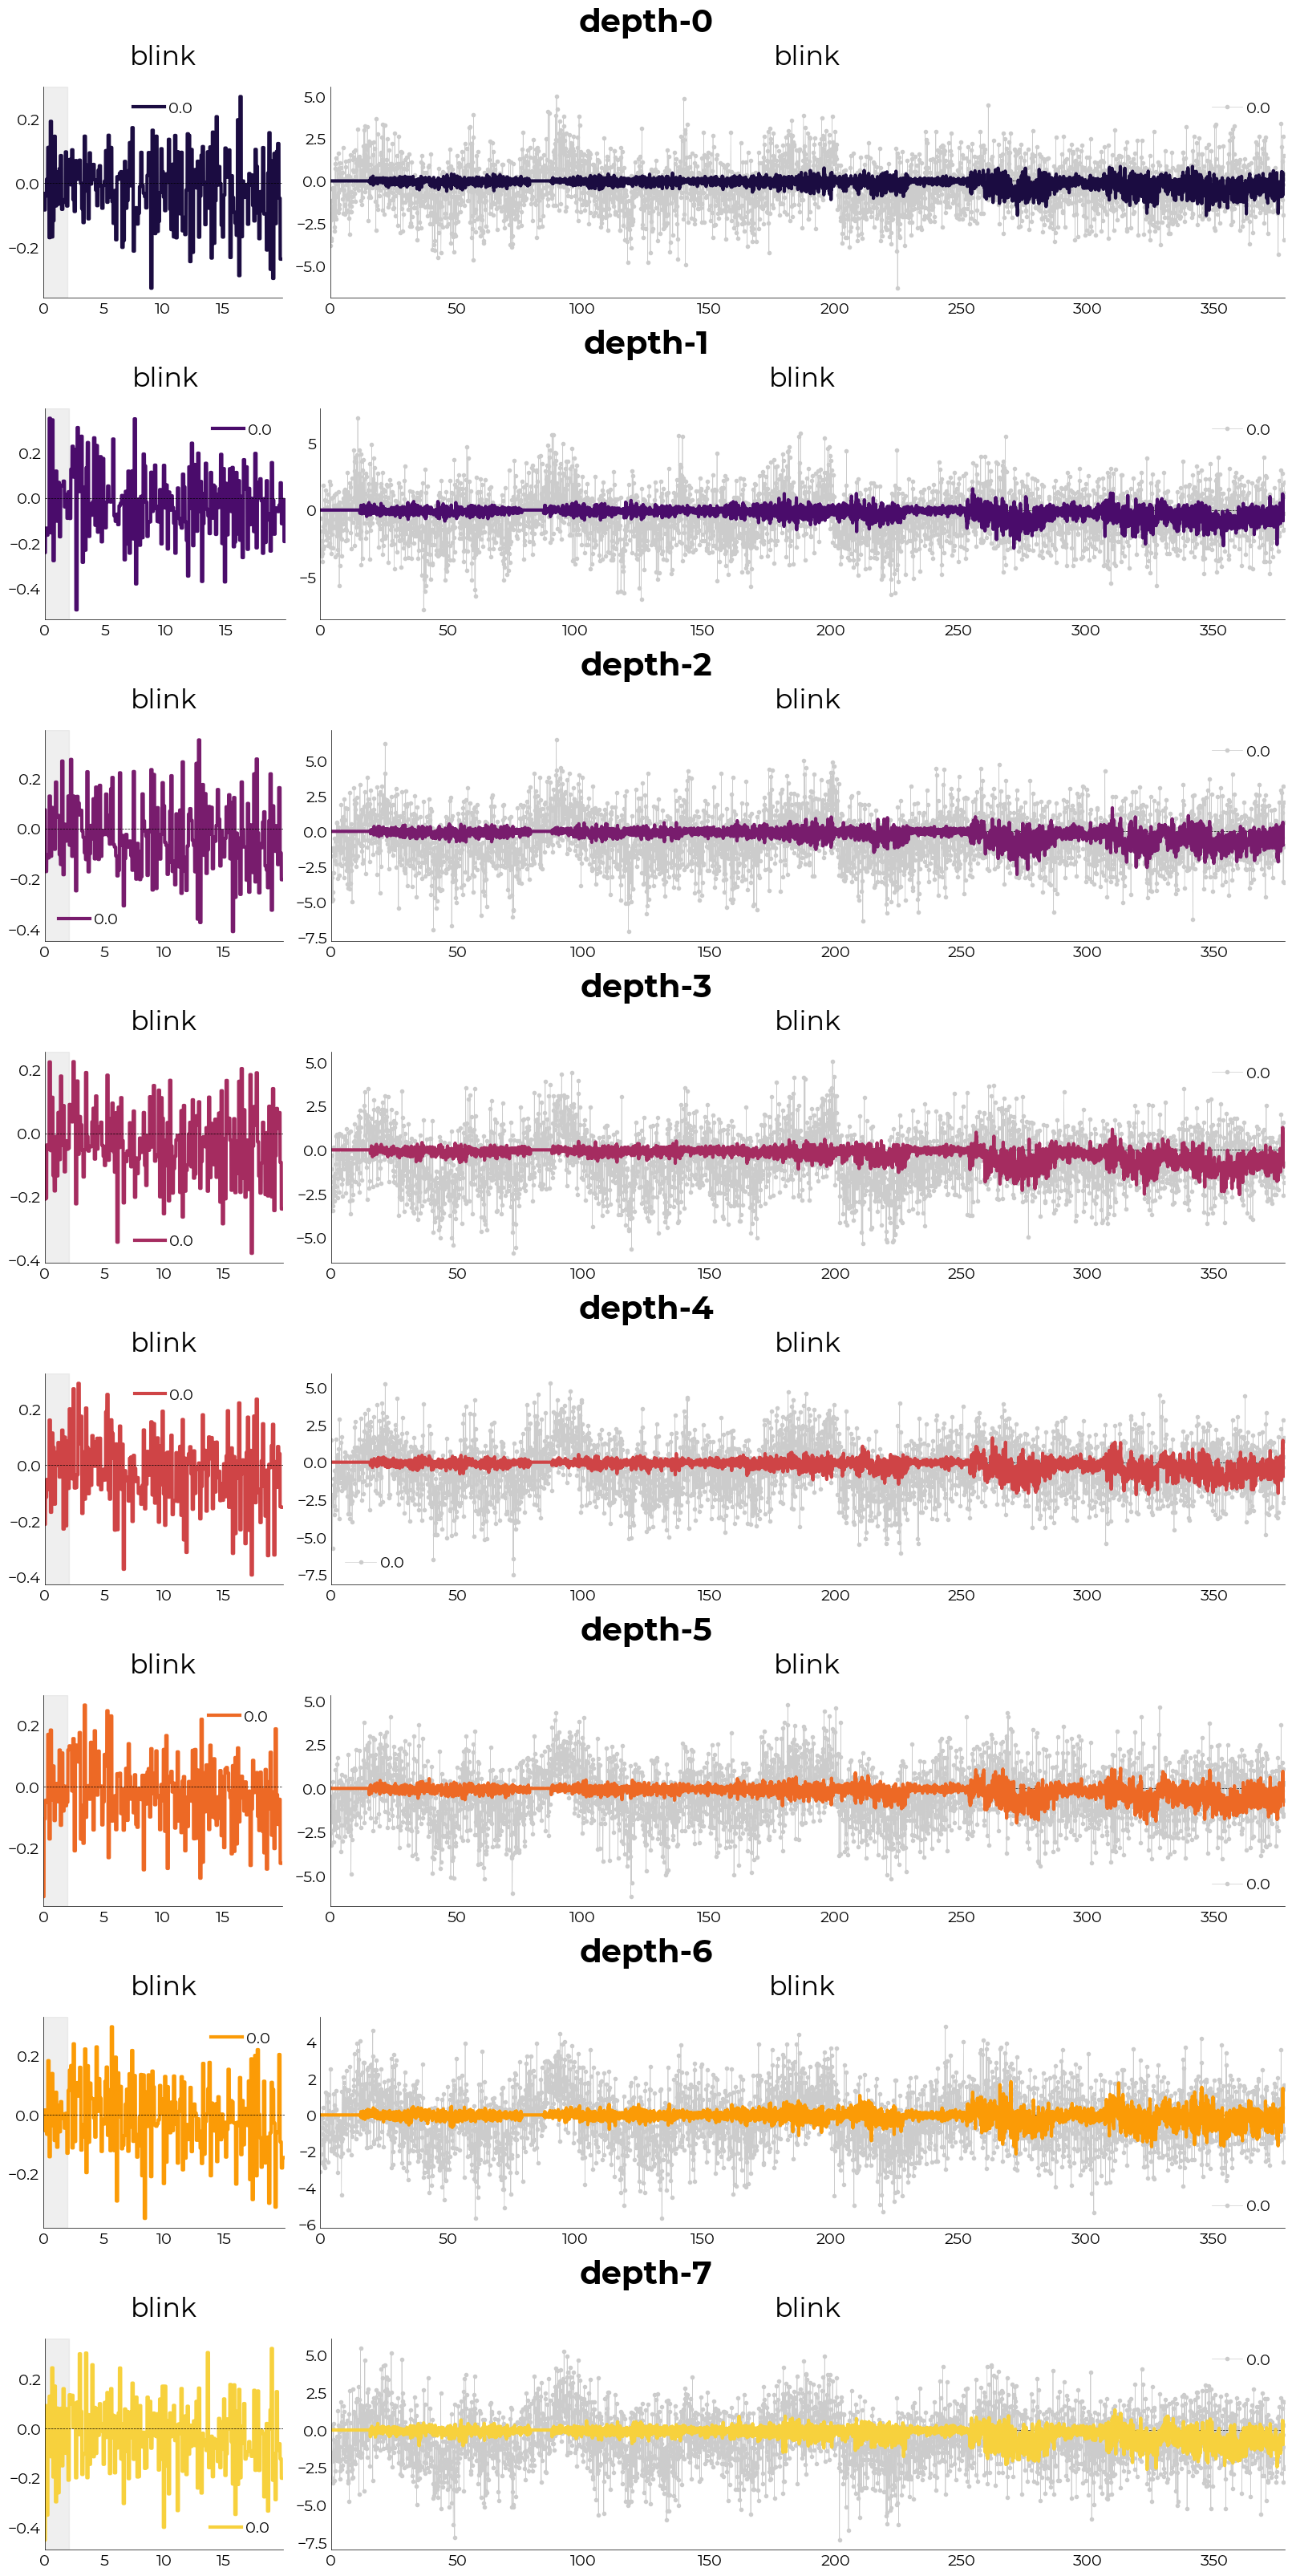

In [ ]:
func_list = list(eye_fir.func.T.values)
fig = plt.figure(figsize=(16,eye_fir.func.shape[-1]*4), constrained_layout=True)
sf = fig.subfigures(nrows=eye_fir.func.shape[-1])

cms = sns.color_palette("inferno", eye_fir.func.shape[-1])
preds = list(eye_fir.sub_pred_full.T.values)
ddict = {}
for ix,tc in enumerate(func_list):

    axs = sf[ix].subplots(ncols=2, width_ratios=[0.2,0.8])

    ddict[f"depth_{ix}"] = {}
    for df_i,(tmp,tag,t_name,sh,col,mk,lw) in enumerate(zip(
        [eye_fir.tc_condition,eye_fir.func],
        ["profile","timecourse"],
        ["time","t"],
        [True,False],
        [[cms[ix]],"#cccccc"],
        [None,"."],
        [3,0.5])):


        df = pd.DataFrame(tmp.iloc[:,ix])
        idx = list(df.index.names)
        df.reset_index(inplace=True)
        df["event_type"] = "blink"
        idx.insert(1,"event_type")
        df.set_index(idx, inplace=True)

        ddict[f"depth_{ix}"][tag] = df.copy()
        hr.viz.PlotDeconvProfiles(
            df,
            inset_par=None,
            time_par=t_name,
            axs=axs[df_i],
            color=col,
            title=tag,
            onset_shade=sh,
            markers=mk,
            line_width=lw
        )
    
    pred_tc = preds[ix]
    ddict[f"depth_{ix}"]["pred"] = pred_tc
    pl = plotting.LazyPlot(
        pred_tc,
        xx=utils.get_unique_ids(eye_fir.func, id="t"),
        color=cms[ix],
        line_width=3,
        axs=axs[1]
    )

    sf[ix].suptitle(f"depth-{ix}", fontweight="bold", fontsize=pl.title_size*1.2)

    # pl = plotting.LazyPlot(
    #     tc, 
    # )

In [ ]:
cleaned = preproc.RegressOut(
    eye_fir.func,
    eye_fir.sub_pred_full
)
cleaned.clean_df

vox 363   vox 364   vox 365   vox 366   vox 367  \
subject task run t                                                           
005     SRFa 4   0.000   -1.583248 -0.078777 -1.115862 -2.755631 -1.877493   
                 0.105   -0.835406 -0.074592 -0.561175 -0.408326  2.014904   
                 0.210   -3.462061 -2.854548 -4.323375 -1.106492 -2.118616   
                 0.315   -1.948396 -1.034742 -2.677754  0.407065 -1.933532   
                 0.420   -3.029489 -2.865793 -4.290944 -2.328821 -1.971753   
...                            ...       ...       ...       ...       ...   
                 377.475  0.466007 -0.854801 -0.425084 -1.897007  0.460121   
                 377.580 -3.107353 -0.991976 -2.764073 -1.360171 -2.507643   
                 377.685  1.745472  1.208585  2.200859 -0.146648  1.400877   
                 377.790  0.273653 -0.343772 -0.860705 -0.702229  0.114780   
                 377.895 -0.171866  2.139302  0.562419  0.022338  1.750815   

                           vox 368   vox 369   vox 370  
subject task run t                                      
005     SRFa 4   0.000   -2.105940 -2.902257 -2.531318  
                 0.105    0.516045  0.029225 -0.862798  
                 0.210   -0.365937 -1.387658  0.901417  
                 0.315   -1.062395  0.040407 -1.188149  
                 0.420   -1.435573 -1.935849 -1.435141  
...                            ...       ...       ...  
                 377.475 -1.193127 -2.708143 -2.850030  
                 377.580  0.380895  1.256556  0.598275  
                 377.685 -1.366337 -0.877535 -2.564466  
                 377.790  0.246471  1.080267  2.140144  
                 377.895  0.217754 -0.845659 -1.758305  

[3600 rows x 8 columns]

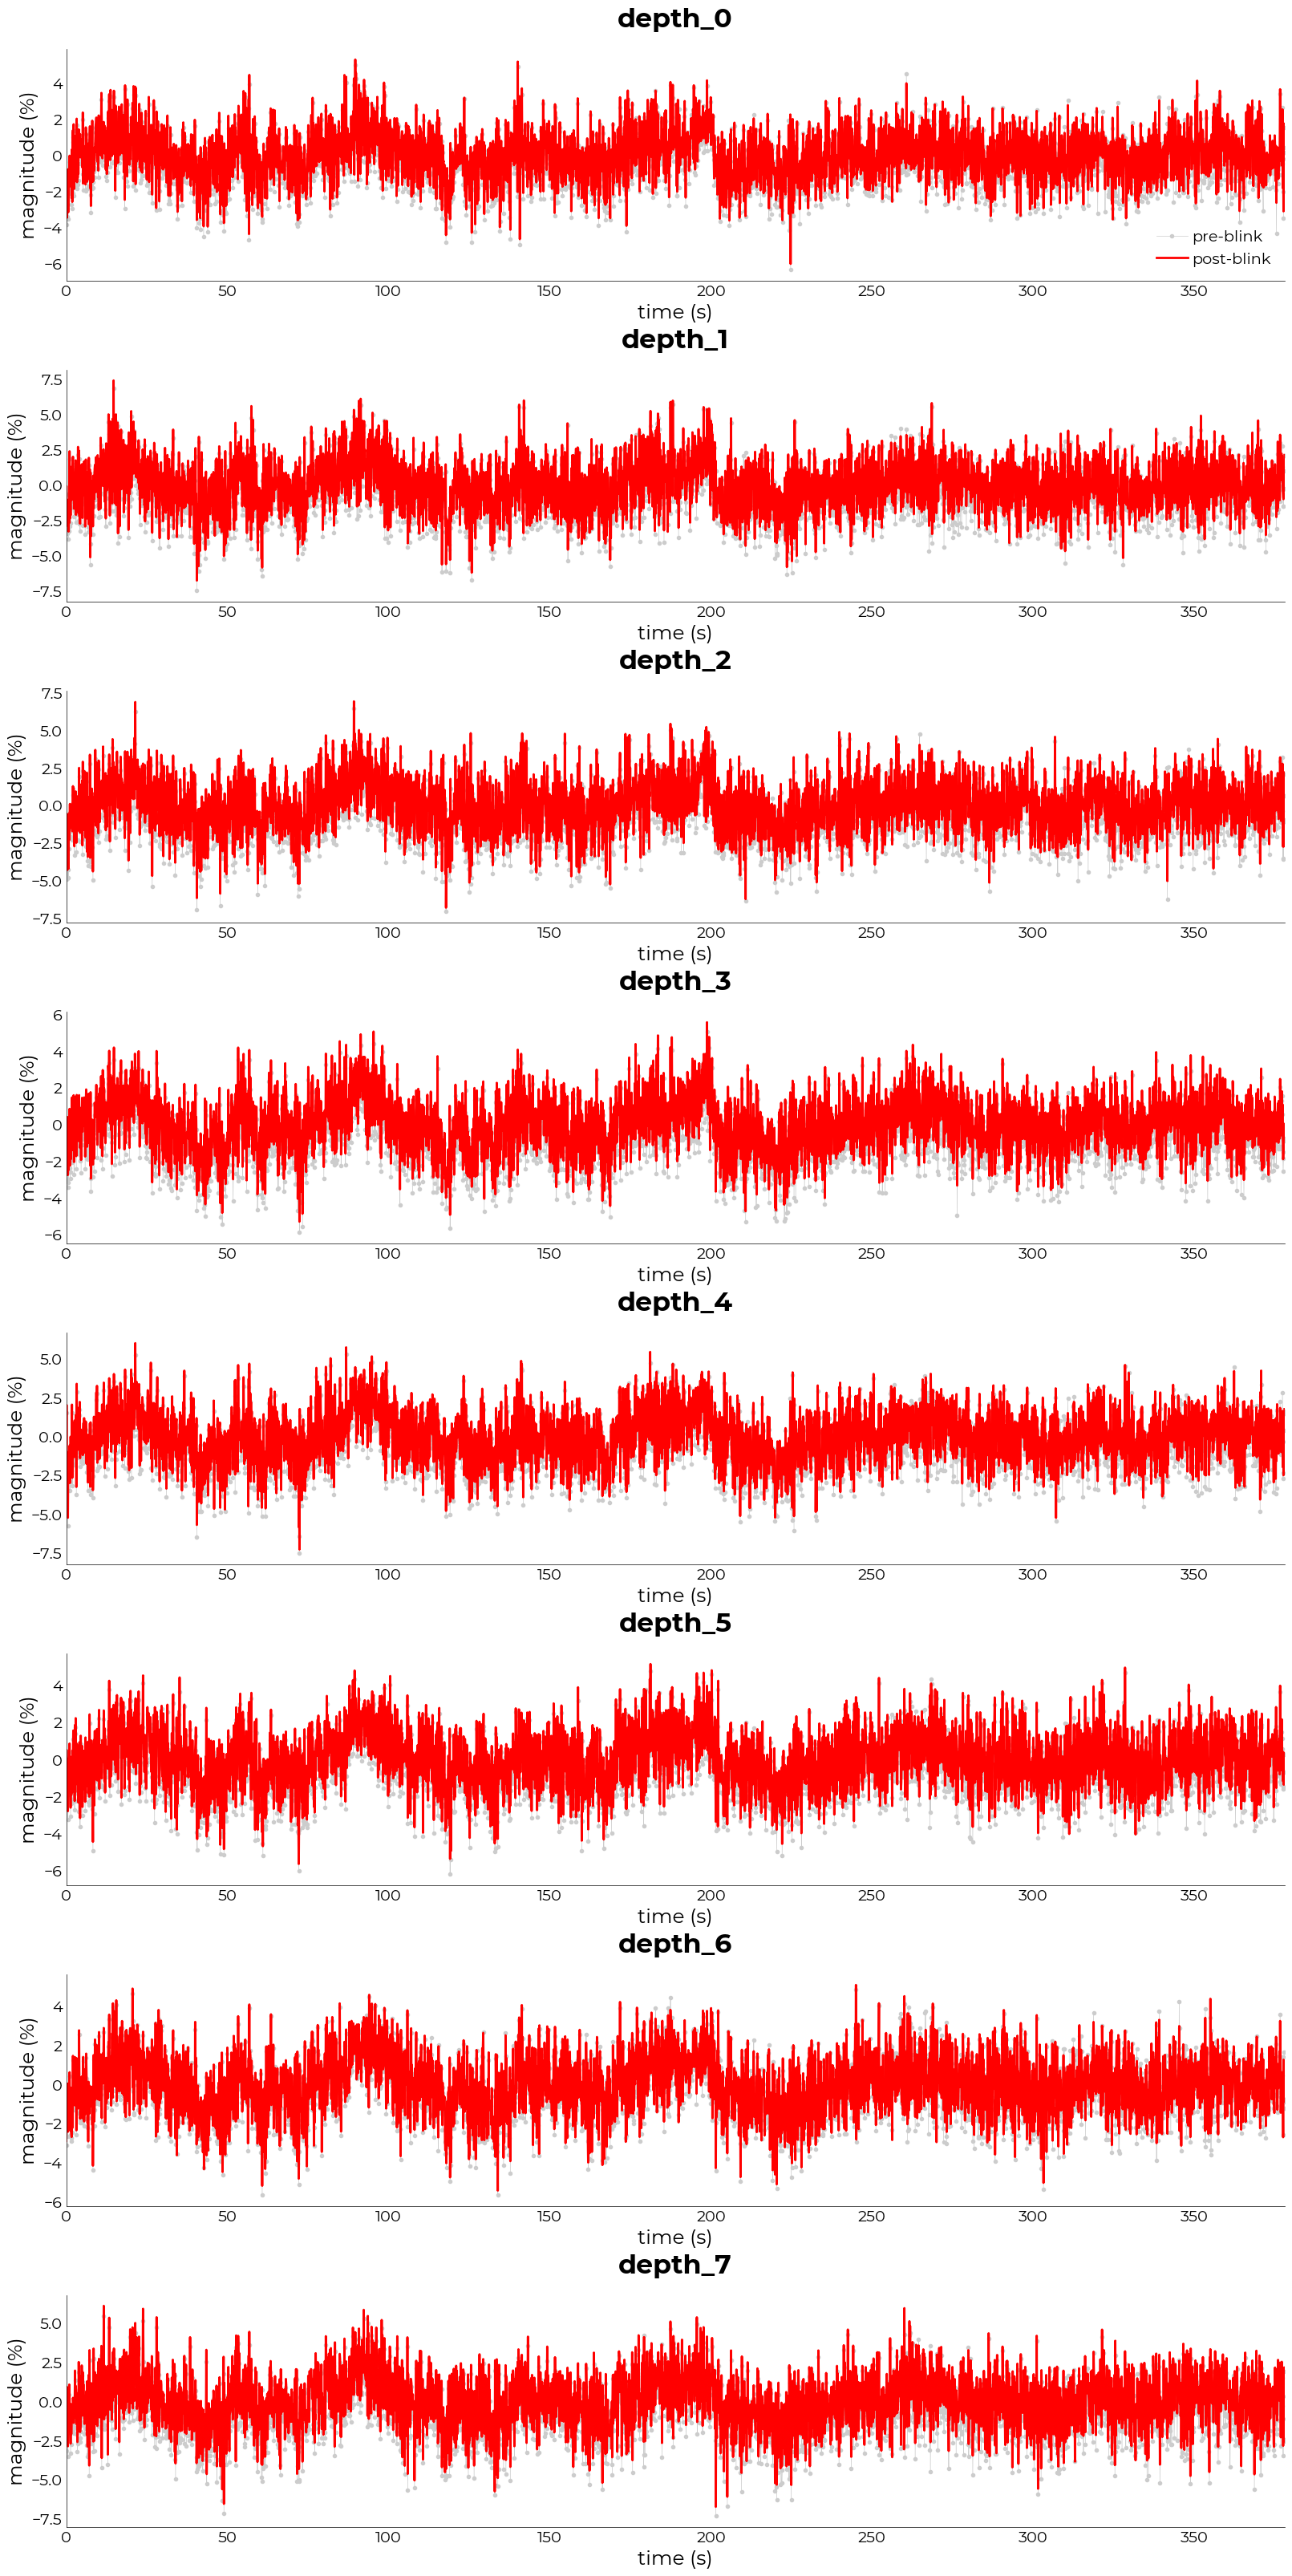

In [ ]:
fig,axs = plt.subplots(nrows=len(ddict), figsize=(16,len(ddict)*4), constrained_layout=True)

# regress out FIR blink prediction
cleaned = preproc.RegressOut(
    eye_fir.func,
    eye_fir.sub_pred_full
)

for ix,(key,val) in enumerate(ddict.items()):
    tc_pre = eye_fir.func.iloc[:,ix].values
    tc_post = cleaned.clean_df.iloc[:,ix].values
    
    if ix == 0:
        lbl = ["pre-blink","post-blink"]
    else:
        lbl = None
        
    plotting.LazyPlot(
        [tc_pre,tc_post],
        xx=utils.get_unique_ids(eye_fir.func, id="t"),
        title={
            "title": key,
            "fontweight": "bold"
        },
        axs=axs[ix],
        markers=[".",None],
        line_width=[0.5,2],
        labels=lbl,
        color=["#cccccc","r"],
        y_label="magnitude (%)",
        x_label="time (s)"
    )

In [ ]:
models = {}

for key,val in objs.items():

    # parse into single dataframe
    rib_df = val["obj"].dict_ribbon["sub-005"]
    rib_on = val["obj"].df_onsets
    ff = hr.data.make_single_df(rib_df)
    oo = hr.data.make_single_df(utils.select_from_df(rib_on, expression=f"subject = 005"), idx=["subject","run","event_type"])
    
    # fit
    can_fit = fitting.NideconvFitter(
        ff,
        oo,
        basis_sets='canonical_hrf_with_time_derivative_dispersion',
        # basis_sets="fourier",
        # n_regressors=4,
        TR=0.105,
        interval=[-2,26],
        verbose=True,
        conf_intercept=True
    )

    can_fit.timecourses_condition()

    models[key] = can_fit

Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative_dispersion'-basis sets (with 3 regressors)
Adding event 'act' to model
Adding event 'suppr_long' to model
Adding event 'suppr_short' to model
Fitting with 'ols' minimization
Done


In [ ]:
models

{'orig': <linescanning.fitting.NideconvFitter at 0x7fcbfcaba040>,
 'long': <linescanning.fitting.NideconvFitter at 0x7fcbfd403310>}

In [ ]:
import seaborn as sns

ev_names = ["center","near","far"]
ev_names2 = ["center","far (2s)","far (4s)"]
subID = "sub-005"
for ix,(key,use_model) in enumerate(models.items()):
    
    evs = [ev_names,ev_names2][ix]
    runIDs = utils.get_unique_ids(use_model.func, id="run")
    fig,axs = plt.subplots(nrows=len(runIDs), figsize=(14,4*len(runIDs)), constrained_layout=True)
    for ix,run in enumerate(runIDs):
        d_ev = utils.select_from_df(use_model.func, expression=f"run = {run}").mean(axis=1).values

        tcs = [d_ev]
        labels = ["data"]
        for ev_ix,ev in enumerate(use_model.cond):

            p_ev = utils.select_from_df(use_model.ev_predictions, expression=(f"run = {run}","&",f"event_type = {ev}")).mean(axis=1).values
            tcs.append(p_ev)
            labels += [evs[ev_ix]]
        
        if len(runIDs)<2:
            ax = axs
        else:
            ax = axs[ix]

        pl = plotting.LazyPlot(
            tcs,
            line_width=[0.5,3,3,3],
            color=["#cccccc"]+subj_obj.get_colors(),
            x_label="volumes",
            y_label="magnitude",
            add_hline=0,
            axs=ax,
            labels=labels,
            # y_lim=[-2.5,2.5],
            title=f"run-{run}"
        )

    fig.suptitle(subID, fontweight="bold", fontsize=pl.title_size*1.3)
    hr.viz._save_figure(
        fig, 
        subject=subID, 
        fname=f"sub-{subID.split('-')[-1]}_ses-{key}_desc-timecourses_filt"
    )

    plt.close()

Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/sub-005/sub-005_ses-orig_desc-timecourses_filt.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/sub-005/sub-005_ses-orig_desc-timecourses_filt.png'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/sub-005/sub-005_ses-long_desc-timecourses_filt.pdf'
Writing '/data1/projects/MicroFunc/Jurjen/programs/project_repos/holeresponse/images/sub-005/sub-005_ses-long_desc-timecourses_filt.png'
